In [1]:
# One way to be sure we don't grab any cuda
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
from functools import partial
from multiprocessing import Pool
from io import StringIO
import argparse
import torch
from pathlib import Path
import wandb
import ast
from omegaconf import OmegaConf

from wyckoff_transformer.generator import WyckoffGenerator
from cascade_transformer.model import CascadeTransformer
from wyckoff_transformer.tokenization import (
    load_tensors_and_tokenisers, tensor_to_pyxtal,
    get_letter_from_ss_enum_idx, get_wp_index)

SyntaxError: invalid syntax (tokenization.py, line 92)

In [4]:
config = OmegaConf.create({"a": {"b": {"c": [1,2]}}})

In [7]:
config.a.b.c

[1, 2]

In [3]:
device = torch.device("cpu")
run = wandb.init(id="maqpu3ee", resume=True)
config = OmegaConf.create(dict(wandb.config))
wandb.finish()
if "tokeniser" in config and isinstance(config.tokeniser, str):
    config.tokeniser = ast.literal_eval(config.tokeniser)
if "model" in config and isinstance(config.model, str):
    config.model = ast.literal_eval(config.model)
if "base_config" in config:
    base_config = OmegaConf.load(Path("yamls", "models", f"{config.base_config}.yaml"))
    config = OmegaConf.merge(base_config, config)
# The start tokens will be sampled from the train+validation datasets,
# to preserve the sanctity of the test dataset and ex nihilo generation.

tensors, tokenisers = load_tensors_and_tokenisers(config.dataset, config.tokeniser.name)    

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kazeev (symmetry-advantage). Use `wandb login --relogin` to force relogin


best_val_loss,16.37654
epoch,29990
known_cascade_len,0
known_seq_len,2
lr,0.00472
train_loss_batch,56399.35156
wp_formal_validity,0.98


In [4]:
generation_size = 100
#del tensors["test"]
# First, we want to compute the unbiased validity number
# Then we drop the underrepresented groups
max_start = len(tokenisers[config.model.start_token])
start_counts = torch.bincount(tensors["train"][config.model.start_token], minlength=max_start) + \
                torch.bincount(tensors["val"][config.model.start_token], minlength=max_start)
underrepresented = start_counts < 10
start_counts[underrepresented] = 0
start_distribution = torch.distributions.Categorical(probs=start_counts.float())

if "augmented_token_fields" not in config.tokeniser:
    tokeniser_config = OmegaConf.load(Path("yamls", "tokenisers", f"{config.tokeniser.name}.yaml"))
    config.tokeniser = tokeniser_config
model = CascadeTransformer.from_config_and_tokenisers(config, tokenisers, device)
model.load_state_dict(torch.load("runs/maqpu3ee/best_model_params.pt", map_location=device))
# We need to grab any tensor from the train dataset
max_sequence_len = tensors["train"][config.model.cascade_order[0]].size(1)
masks = {field: tokenisers[field].mask_token for field in config.model.cascade_order}
generator = WyckoffGenerator(model, config.model.cascade_order, masks, max_sequence_len)
start = start_distribution.sample((generation_size,))
generated_tensors = torch.stack(generator.generate_tensors(start), dim=-1)
print(generated_tensors.size())

letter_from_ss_enum_idx = get_letter_from_ss_enum_idx(tokenisers['sites_enumeration'])
to_pyxtal = partial(tensor_to_pyxtal,
                    tokenisers=tokenisers,
                    cascade_order=config.model.cascade_order,
                    letter_from_ss_enum_idx=letter_from_ss_enum_idx,
                    wp_index=get_wp_index())
#with Pool() as p:
from itertools import starmap
import logging
logging.basicConfig(level=logging.DEBUG)
generated_wp = starmap(to_pyxtal, zip(start.detach().cpu(), generated_tensors.detach().cpu()))
generated_wp = [s for s in generated_wp if s is not None]
wp_formal_validity = len(generated_wp) / generation_size
print(f"Wyckchoffs formal validity: {wp_formal_validity}")

torch.Size([100, 21, 3])
Wyckchoffs formal validity: 0.98


In [5]:
generated_wp[0]

{'group': 139,
 'sites': [['4d'], ['2b'], ['4e']],
 'species': ['Ni', 'Ga', 'Ge'],
 'numIons': [4, 2, 4]}

In [6]:
import pyxtal
p_st = pyxtal.pyxtal()

In [7]:
p_st.from_random(3, **generated_wp[0])

In [10]:
p=p_st.to_pymatgen()

In [35]:
import gzip, pickle
with gzip.open("cache/mp_20_biternary/data.pkl.gz", "rb") as f:
    data = pickle.load(f)

In [39]:
data['train']['composition'].iloc[0]

{Element Nd: 1.0, Element Al: 8.0, Element Cu: 4.0}

In [32]:
p.composition.get_el_amt_dict()

{'Ga': 2.0, 'Ge': 4.0, 'Ni': 4.0}

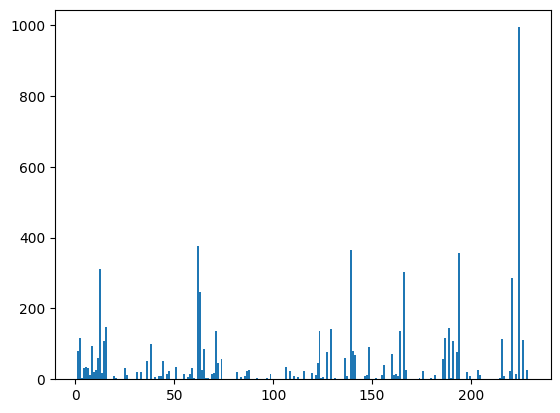

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist([tokenisers['spacegroup_number'].to_token[x] for x in start], bins=230);

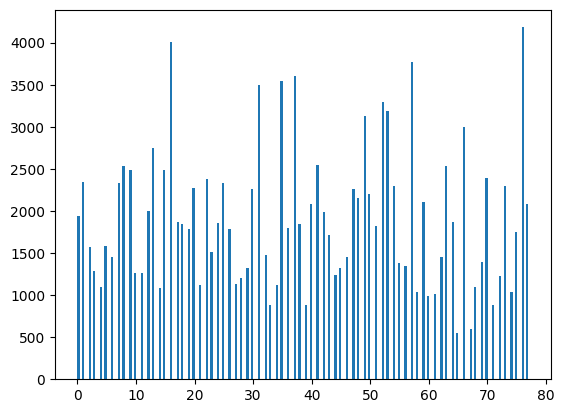

In [ ]:
plt.hist(generated_tensors[:, :, 1].numpy().flatten(), bins=200);

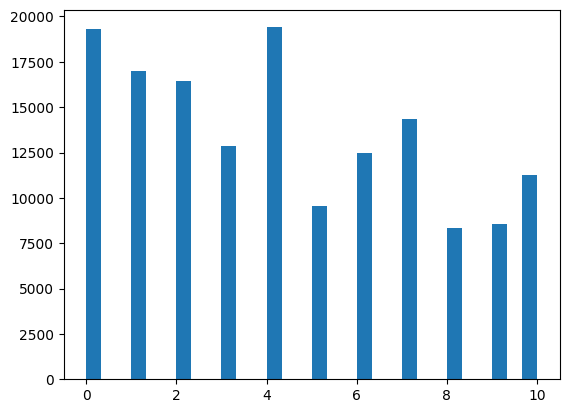

In [ ]:
plt.hist(generated_tensors[:, :, 2].numpy().flatten(), bins=30);

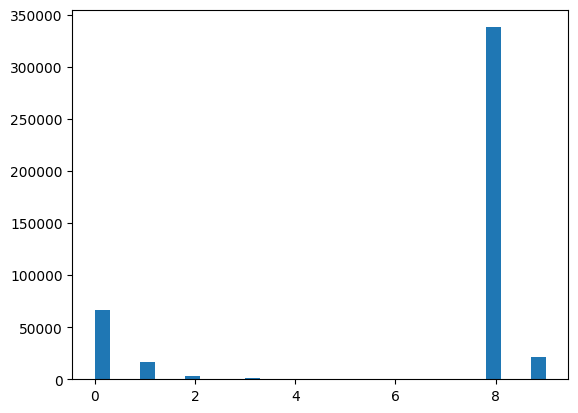

In [ ]:
plt.hist(tensors['train']['sites_enumeration'].flatten(), bins=30);

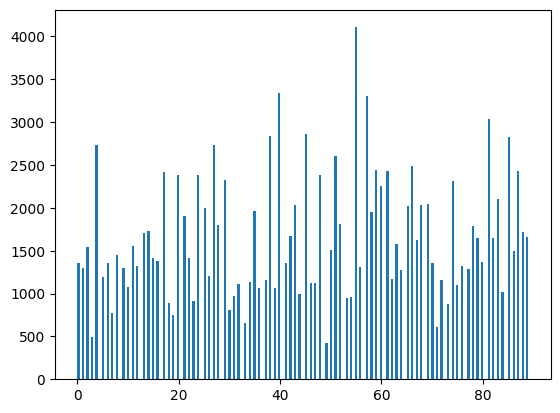

In [ ]:
plt.hist(generated_tensors[:, :, 0].numpy().flatten(), bins=200);

In [ ]:
generated_tensors.shape

torch.Size([7118, 21, 3])

In [ ]:
generated_tensors.shape

torch.Size([7118, 21, 3])

In [ ]:
letter_from_ss_enum_idx

defaultdict(dict,
            {1: {'1': {0: 'a'}},
             2: {'-1': {0: 'a',
               1: 'b',
               2: 'c',
               3: 'd',
               4: 'e',
               5: 'f',
               6: 'g',
               7: 'h'},
              '1': {0: 'i'}},
             3: {'2': {0: 'a', 1: 'b', 2: 'c', 3: 'd'}, '1': {0: 'e'}},
             4: {'1': {0: 'a'}},
             5: {'2': {0: 'a', 1: 'b'}, '1': {0: 'c'}},
             6: {'m': {0: 'a', 1: 'b'}, '1': {0: 'c'}},
             7: {'1': {0: 'a'}},
             8: {'m': {0: 'a'}, '1': {0: 'b'}},
             9: {'1': {0: 'a'}},
             10: {'2/m': {0: 'a',
               1: 'b',
               2: 'c',
               3: 'd',
               4: 'e',
               5: 'f',
               6: 'g',
               7: 'h'},
              '2': {0: 'i', 1: 'j', 2: 'k', 3: 'l'},
              'm': {0: 'm', 1: 'n'},
              '1': {0: 'o'}},
             11: {'-1': {0: 'a', 1: 'b', 2: 'c', 3: 'd'},
              'm': {

In [ ]:
tokenisers['elements'].to_token[27]

Element Zn

In [ ]:
tokenisers['site_symmetries'].to_token[71]

'2/m2/m.'

In [ ]:
tokenisers['sites_enumeration'].to_token[8]

'PAD'

In [ ]:
tokenisers['spacegroup_number'].to_token[start[0]]

12

In [ ]:
tokenisers['spacegroup_number'][12]

11

In [ ]:
run = wandb.init(id="0r6dpswx", resume=True)
valid_structures = list(map(pyxtal_generate, generated_wp))
valid_structures = [s for s in valid_structures if s is not None]
pyxtal_success_rate = len(valid_structures) / len(generated_wp)
print(f"Pyxtal success rate: {pyxtal_success_rate}")
for s in valid_structures:
    wandb.log({"structure": wandb.Molecule(s, file_type="cif")}, commit=True)
#valid_strucutes = [wandb.Molecule(s, file_type="cif") for s in valid_structures]
wandb.finish()

best_val_loss,17.2129
epoch,4990
known_cascade_len,0
known_seq_len,4
lr,1
pyxtal_generated_fraction,0
train_loss_batch,11212.93262
wp_formal_validity,0


DEBUG:git.cmd:Popen(['git', 'cat-file', '--batch-check'], cwd=/home/kna/WyckoffTransformer, stdin=<valid stream>, shell=False, universal_newlines=False)


long time to generate structure, check inputs
long time to generate structure, check inputs
long time to generate structure, check inputs
long time to generate structure, check inputs
long time to generate structure, check inputs
long time to generate structure, check inputs
